# Descriptive Text Mining

Programmazione di Applicazioni Data Intensive \
Laurea in Ingegneria e Scienze Informatiche  \
DISI - Università di Bologna, Cesena

Obiettivo: dai post di una comunità virtuale di pazienti affetti dalla malattia rara Acalasia Esofagea che descrivono le esperienze dei pazienti, individuare, mediante analisi semantica con LSA, le cause che contribuiscono ai punti di vista dei pazienti su sintomi, trattamenti, medicinali e alimenti.

## Librerie impiegate

In [1]:
!pip install spacy -U
!python -m spacy download it_core_news_sm

     |████████████████████████████████| 21.4 MB 7.1 MB/s            
✔ Download and installation successful
You can now load the package via spacy.load('it_core_news_sm')


In [56]:
from os import path, makedirs
from tabulate import tabulate
from urllib.request import urlretrieve
import numpy as np
from numpy.linalg import norm
import pandas as pd
import spacy
import re
import pickle
from operator import itemgetter

from matplotlib import pyplot as plt
from matplotlib.colors import from_levels_and_colors
import plotly.graph_objects as go
import plotly.express as px

import scipy.sparse as sp
from scipy.sparse import csr_matrix
from scipy.stats import chi2_contingency

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.utils.extmath import randomized_svd
from sklearn.metrics.pairwise import cosine_similarity

In [3]:
images_path = "./"
makedirs(images_path, exist_ok = True)
get_path = lambda fname, fformat : path.join(images_path, fname + "." + fformat)
savefig = lambda fname, fformat : plt.savefig(get_path(fname, fformat), fformat = fformat)

## Funzioni impiegate

In [4]:
def reduce_lengthening(message):
    pattern = re.compile(r"(.)\1{2,}")
    return pattern.sub(r"\1\1", message)

def reduce_lengthening_all(messages):
    if isinstance(messages, str):
        messages = [messages]
    reduced_messages = map(lambda m: reduce_lengthening(m), messages)
    return list(reduced_messages)

In [5]:
def normalize_emotes(df):       
    # EMOTEGOOD :) :-) :] :-] =) =] => :> ^^ ^_^ ^-^ ^o^ : ) (: :'D
    df.original_text = df.original_text.str.replace(
        "\\:\\)+|\\:\\-\\)+|\\:\\]+|\\:\\-\\]+|\\=\\)" +
        "|\\=\\]+|\\=\\>|\\:\\>|\\^\\^|\\^\\_" + 
        "\\^|\\^\\-\\^|\\^o\\^|\\:[[:blank:]]\\) " +
        "|[[:blank:]]\\([[:blank:]]?\\:|\\:\\'D+",
        " emotegood ",
        regex = True
    )
    
    # EMOTEGOOD :d :D :-d :-D =d =D 8d 8D :')
    df.original_text = df.original_text.str.replace(
        "\\:d+|\\:D+|\\:\\-d+|\\:\\-D+|\\=d" + 
        "|\\=D+|8d+|8D+|\\:\\'+\\)+|v\\.v",
        " emotegood ",
        regex = True
    )
    
    # EMOTELOVE <3 :*
    df.original_text = df.original_text.str.replace(
        "\\<3+|\u2764|\u2665|\\:\\*+",
        " emotelove ",
        regex = True
    )
    
    # EMOTEBAD :( :-( :[ :-[ =[ =( : ( ):
    df.original_text = df.original_text.str.replace(
        "\\:\\(+|\\:\\-\\(+|\\:\\[+|\\:\\-\\[+|\\=\\[+|\\=\\(" + 
        "|\\:[[:blank:]]\\(|[[:blank:]]\\([[:blank:]]?\\:",
        " emotebad ",
        regex = True
    )
  
    # EMOTEBAD :'( :-[ D:
    df.original_text = df.original_text.str.replace(
        "\\:\\'+\\(+|\\:\\'\\[|D\\:|\\:\\-\\[",
        " emotebad ",
        regex = True
    )
    
    # EMOTEBAD :| :/ =/ :x :-|
    df.original_text = df.original_text.str.replace(
        "\\:\\|\\:/+|\\=/+|\\:x",
        " emotebad ",
        regex = True
    )
    
    # EMOTEBAD #_# X_X x_x X.X x.x >.< >_< >.> >_>
    df.original_text = df.original_text.str.replace(
        "\\#\\_+\\#|X\\_+X|x\\_+x|X\\.X|x\\.x|>\\.<|>\\_" +
        "<|>\\_+>|>\\.>",
        " emotebad ",
        regex = True
    )
    
    # EMOTEWINK ;) ;-) ;] ;-] ;> ;d ;D ;o
    df.original_text = df.original_text.str.replace(
        "\\;\\)+|\\;\\-\\)+|\\;\\]|\\;\\-\\]|\\;\\>|;d+|;D+|;o",
        " emotewink ",
        regex = True
    )
    
    # EMOTESHOCK O.o o.o O.O o.O O_o o_o O_O o_O etc
    df.original_text = df.original_text.str.replace(
        "O\\.o|o\\.o|O\\.O|o\\.O|O\\_+o|o\\_+o|O\\_+O|o\\_+O|\\:OO" + 
        "|\\=O+|\\-\\.\\-|u\\.u|u\\.\u00F9|\u00F9\\.u|u\\_" + 
        "u|\u00E7\u00E7|\u00E7_+\u00E7|t_+t|\u00F9\\_" + 
        "\u00F9|\u00F9\\.\u00F9|\\:oo+|0\\_+0|\\=\\_" + 
        "\\=|\\.\\_+\\.|\u00F2\u00F2|\u00F2\\_+\u00F2|\\*u+\\*|\\-\\_" +
        "\\-|\u00F9\u00F9|\\-\\,\\-|\\-\\-\\'|\\.\\-\\.|\\'\\-\\'",
        " emoteshock ",
        regex = True
    )

    # EMOTEAMAZE *_* *-* *o* *.*
    df.original_text = df.original_text.str.replace(
        "\\*\\_+\\*|\\*\\-\\*|\\*\\.\\*",
        " emoteamaze ",
        regex = True
    )
    
    # EMOTEJOKE :P :p =P =p XD xD xd d:
    df.original_text = df.original_text.str.replace(
        "\\:P+[^e]|\\:p+[^e]|\\=P+|\\=p+|XD+|xD+|xd+|[[:blank:]]d\\:",
        " emotejoke ",
        regex = True
    )

In [6]:
def makequery(qterms, tdm, U, s, vocabulary):
    query = np.zeros(tdm.shape[0])

    # one hot query
    query[[vocabulary.get(term) for term in qterms]] = 1
    # weighted query
    wquery = np.log(query + 1) * (1 - entropy(tdm, axis = 1))
    # folded query
    qls = np.matmul(wquery.T, U)

    # normalized query
#     qlsn = norm(qls, 2)
#     qlsn = qls / qlsn

    # cosine similary query term
    dk = np.matmul(qls, np.diag(np.power(s, -1)))
    dksrs = np.matmul(dk, np.diag(np.sqrt(s)))

    return qterms, query, wquery, qls, dk, dksrs

In [7]:
def get_matching_docs(a, b):
    a = np.asarray(a)
    b = np.asarray(b)
    return np.isin(a, b).sum()

In [8]:
def entropy(m, axis = 0):
    m = np.asarray(m)
    p = 1.0 * m / np.sum(m, axis = axis, keepdims = True)
    ndocs = m.shape[axis]
    vec = (p * np.log(p, out = np.zeros_like(p), where = (p!=0))) / np.log(ndocs)
    entropy = - np.sum(vec, axis = axis)
    return entropy

In [9]:
def get_word_counts(m, col_mask, row_mask):
    # get only doc_class related docs
    sliced = tdm[:, col_mask]
    
    # slice rows, get only columns with at least one of 
    # the entries in the row mask.
    sliced = sliced[row_mask, :]
    
    with_word = get_occ_word_all_docs(sliced)
    total = col_mask.sum()
    without_word = total - with_word
    return with_word, without_word

def get_occ_word_all_docs(sliced):
    # logical AND applied to all rows, one for each term
    # in the list.
    rows = [row for row in sliced]
    tmp = np.asarray(sliced[0])
    for row in rows:
        b = np.logical_and(tmp, row)
        tmp = b
    b = np.asarray(b)[0]
    return b.sum()

In [10]:
def term_analysis(
    terms,
    doc_classes,
    without_word_in,
    with_word_in,
    without_word_out,
    with_word_out):  
    
    get_term_doc_df = \
        lambda data, terms, doc_classes : pd.DataFrame(
            data,
            index = [f"not {terms}", f"{terms}"], 
            columns = [f"not {doc_classes}", f"{doc_classes}"]
        )   
    
    terms = "_".join(terms)
    doc_classes = "_".join(doc_classes)
    
    observed = [
        [without_word_out, without_word_in],
        [with_word_out, with_word_in]
    ]
    observed = get_term_doc_df(observed, terms, doc_classes)

    chi2, p, ddof, expected = chi2_contingency(
        observed,
        correction = False
    )
    expected = get_term_doc_df(expected, terms, doc_classes)

    print(f"Pearson's Chi-squared test with {ddof} ddof")
    print("--------------------------------------\n")
    print("Observed frequencies") 
    print(tabulate(observed, headers='keys', tablefmt='psql'))
    print("\nExpected frequencies")
    print(tabulate(expected, headers='keys', tablefmt='psql'))
    print(f"\nX-squared: \t{chi2}")
    print(f"p-value \t{p}")

In [117]:
def get_similar(m, q, docs, threshold=0, topn=10):
    if threshold >= 1.0 or threshold < 0:
        raise("Threshold must be in (0,1]")
    
    docs = np.asarray(docs)
    docs = docs.reshape(docs.shape[0], 1)
    q = np.asarray(q)
    q = q.reshape(1, m.shape[1])
    query2doc = cosine_similarity(q, m)
    query2doc = query2doc.T
    
    mask = query2doc > threshold
    query2doc_masked = query2doc[mask]
    docs_masked = docs[mask]

    docs_idx = [idx for idx, elem in enumerate(mask) if elem == 1]

    # use a structured array
    dtype = [("id", int), ("doc", docs.dtype), ("sim_val", float)]
    ranks = [(z, y, x) for x, y, z in zip(query2doc_masked, docs_masked, docs_idx)]
    ranks = np.array(ranks, dtype = dtype)
    ranks = np.sort(ranks, order = "sim_val")
    ranks = ranks[::-1]  # docs in decreasing order
    
    nranks = len(ranks)
    if topn < nranks:
        ranks = ranks[:topn] # show only first top n matches
    return list(ranks)

In [12]:
def plot_lsa2D(x, y, terms=None):
    fig = go.Figure()

    if terms is None:
        trace = go.Scatter(
            x=x,
            y=y,
            mode="markers+text",
            name="Markers and Text")
    else:
        trace = go.Scatter(
                    x=x,
                    y=y,
                    mode="markers+text",
                    name="Markers and Text",
                    text=terms,

                    textposition="bottom center",
                    textfont=dict(
                        family="sans serif",
                        size=9))

    fig.add_trace(trace)
    fig.update_layout(
        height=800,
        template = "none"
    )
    fig.update_traces(marker=dict(size=3,))
#     fig.update_layout(title_text = "Visualizing LSA")
    return fig

In [13]:
def plot_knee_points(s):
    xlen = 20
    fordiff = lambda x : x[1:len(x)] - x[0:(len(x) - 1)]
    skd = fordiff(s)
    skdd = fordiff(skd)
    skcurv = skdd[0:xlen] / np.power(1 + np.power(skd[0:xlen], 2), 1.5)
    
    plt.figure(figsize=(12, 8))
    plt.plot(np.linspace(1, xlen, xlen), skcurv, "k.-")
    return plt

In [14]:
def plot_lsa2D_termdoc(classes, d1, d2, t1, t2, ord_terms):
    dfc = pd.DataFrame(
        {"Legenda" : classes,
         "lsa1" : d1,
         "lsa2" : d2}
    )

    dfc.Legenda = dfc.Legenda.cat.rename_categories(
        {"Neutral" : "Opinione neutrale",
         "Positive" : "Opinione positiva",
         "Negative" : "Opinione negativa"}
    )

    fig = plot_lsa2D(t1, t2, ord_terms)

    fig1 = px.scatter(
        dfc,
        x = "lsa1",
        y = "lsa2",
        color="Legenda",
        color_discrete_map=
        {"Opinione neutrale": "lightgrey",
         "Opinione positiva": "green",
         "Opinione negativa": "orange"},
        template = "none",
        height = 800
    )

    fig.update_traces(name = "Termini", marker_color="blue")
    fig = go.Figure(data = fig1.data + fig.data)
    fig.update_traces(marker=dict(size=3,))
    fig.update_layout(
        height=800,
        template = "none"
    )
    fig.update_traces(marker=dict(size=3,))
    
    return fig

In [15]:
def chisquare_lsa(qclasses, qterms, query_matching_idxs, classes, dls_rows):
    doc_classes = ["Negative"]
    terms = ["roma", "gemelli"]
    destroyed_idx = np.asarray(classes == qclasses[0])
    doc_mask = destroyed_idx != 0

    query_mask = np.zeros(dls_rows)
    query_mask[query_matching_idxs] = 1

    mask = np.logical_and(doc_mask, query_mask)
    total = doc_mask.sum()
    with_word_in = mask.sum()
    without_word_in = total - with_word_in

    doc_mask = ~doc_mask
    mask = np.logical_and(doc_mask, query_mask)
    total = doc_mask.sum()
    with_word_out = mask.sum()
    without_word_out = total - with_word_out

    term_analysis(
        qterms,
        qclasses,
        without_word_in,
        with_word_in,
        without_word_out,
        with_word_out
    )

In [16]:
def get_query_result(
    docs,
    ord_terms,
    dls,
    tls,
    qls,
    tlsn,
    r=482,
    low=0.2,
    high=0.85):
    
    # get matching docs
    docs_ranked = get_similar(
        dls,
        qls,
        docs,
        threshold = low,
        topn = r
    )
    
    # get matching terms
    terms_ranked = get_similar(
        tls[:,0:6],
        qls[0:6],
        ord_terms,
        threshold = low,
        topn = r
    )
    terms_ranked = [rank for rank in terms_ranked if rank[2] > high]
    sim_scores_reduced_idx = [rank[0] for rank in terms_ranked]
    norms = tlsn[sim_scores_reduced_idx]
    
    return docs_ranked, terms_ranked, norms

In [54]:
def get_ord_terms(vocabulary):
    return np.asarray(
        [t for t, i in sorted(vocabulary.items(), key=itemgetter(1))],
        dtype=object,
    )

## Caricamento della matrice termini documenti

In [20]:
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    data_path = "./"
else:
    plt.style.use('science')
    data_path = "../data/"

base_url = "https://raw.githubusercontent.com/Da3dalu2/thesis-notebooks/main/data/"

In [21]:
dataset_name = "gs_neg.csv"

if not path.exists(data_path + dataset_name):
    dataset_url = base_url + dataset_name
    urlretrieve(dataset_url, dataset_name)

gs_neg = pd.read_csv(
    data_path + dataset_name,
    dtype={"doc1" : "string", "doc2" : "string"}
)

In [22]:
dataset_name = "gs_pos.csv"

if not path.exists(data_path + dataset_name):
    dataset_url = base_url + dataset_name
    urlretrieve(dataset_url, dataset_name)

gs_pos = pd.read_csv(
    data_path + dataset_name,
    dtype={"doc1" : "string", "doc2" : "string"}
)

In [23]:
dataset_name = "slang.csv"

if not path.exists(data_path + dataset_name):
    dataset_url = base_url + dataset_name
    urlretrieve(dataset_url, dataset_name)

slang_words = pd.read_csv(
    data_path + dataset_name
)

In [112]:
dataset_name = "tdm.npz"

# if not path.exists(data_path + dataset_name):
#     dataset_url = base_url + dataset_name
#     urlretrieve(dataset_url, dataset_name)

tdm = sp.load_npz(dataset_name)
tdm = tdm.todense()
b = (1 - entropy(tdm, axis = 1))
b = np.array(b)

a = np.log(tdm + 1)
a = np.array(a)

wtdm = (a.T * b).T
wtdm = csr_matrix(wtdm)

In [113]:
wtdm

<1049x3293 sparse matrix of type '<class 'numpy.float64'>'
	with 32078 stored elements in Compressed Sparse Row format>

In [114]:
wtdm.astype(bool).mean()

0.009286243431121922

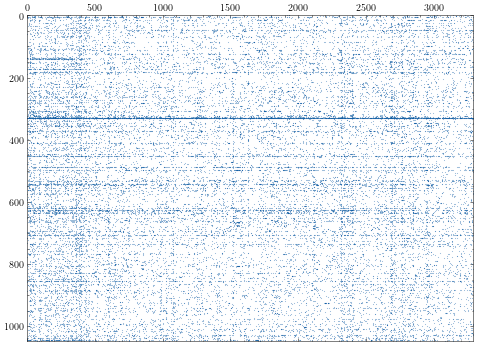

In [115]:
fig = plt.figure()
plt.spy(wtdm, markersize=0.10, aspect = 'auto')
fig.set_size_inches(8,6)

In [52]:
file_name = 'vocabulary.sav'
vocabulary = pickle.load(open(file_name, 'rb'))

In [58]:
ord_terms = get_ord_terms(vocabulary)

In [103]:
file_name = 'doc_classes.sav'
doc_classes = pd.read_pickle(file_name)

## Analisi semantica latente

In [82]:
k = 100
U, s, Vh = randomized_svd(wtdm, n_components = k, random_state = 5)

In [83]:
s.shape

(100,)

In [84]:
U.shape

(1049, 100)

In [85]:
Vh.shape

(100, 3293)

In [86]:
Vh = Vh.transpose()

In [87]:
Vh.shape

(3293, 100)

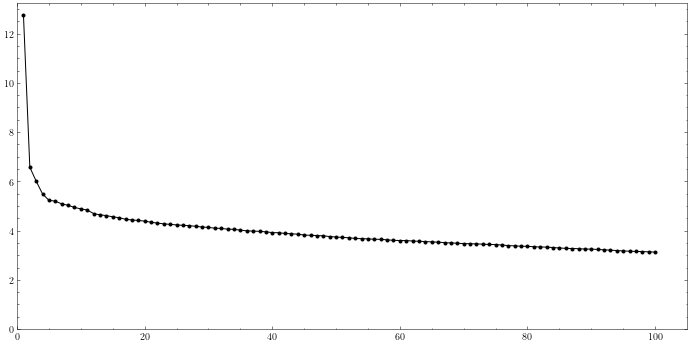

In [88]:
plt.figure(figsize=(12, 6))
plt.plot(np.linspace(1, k, k), s, "k.-")
plt.ylim(bottom=0)
plt.xlim(xmin=0)
savefig("power_law_svd", "pdf")

In [89]:
# U è chiamata tk (lsar$tk), S è sk (lsar$sk), V^t è dk (lsar$dk)
tls = np.matmul(U, np.diag(s))
dls = np.matmul(Vh, np.diag(s))

In [90]:
tls.shape

(1049, 100)

In [91]:
dls.shape

(3293, 100)

## Visualizzazione dello spazio trasformato

Visualizzazione dei termini nelle prime due dimensioni latenti

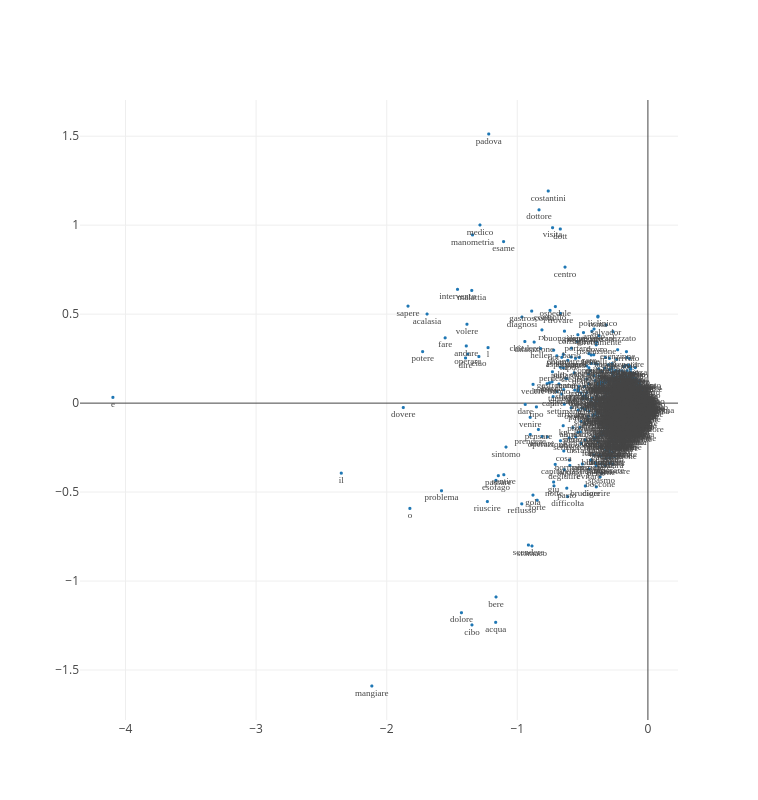

In [92]:
plot_lsa2D(-1*tls[:,0], -1*tls[:,1], ord_terms)

In [93]:
get_norm = lambda v : np.sqrt(np.sum(np.power(v, 2)))

In [94]:
terms_norm_lsa = np.zeros(len(tls[:,]))
for idx, col in enumerate(tls):
    terms_norm_lsa[idx] = get_norm(col)

In [95]:
tls_terms_norm = np.column_stack((tls, terms_norm_lsa))
tls_terms_norm.shape

(1049, 101)

In [96]:
tls.shape

(1049, 100)

In [97]:
tls_terms_norm.shape

(1049, 101)

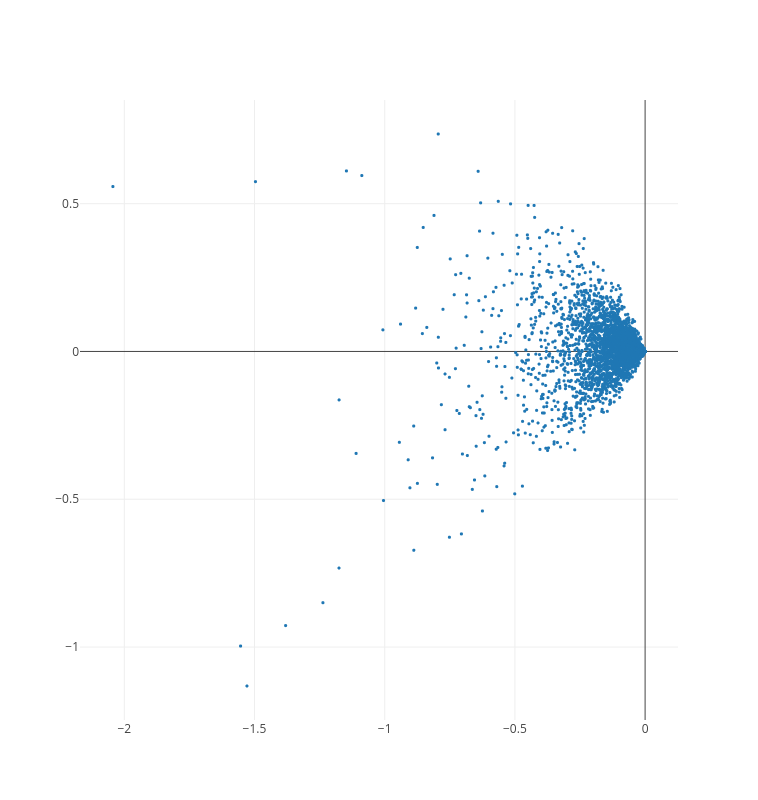

In [98]:
plot_lsa2D(-1*dls[:,0], -1*dls[:,1])

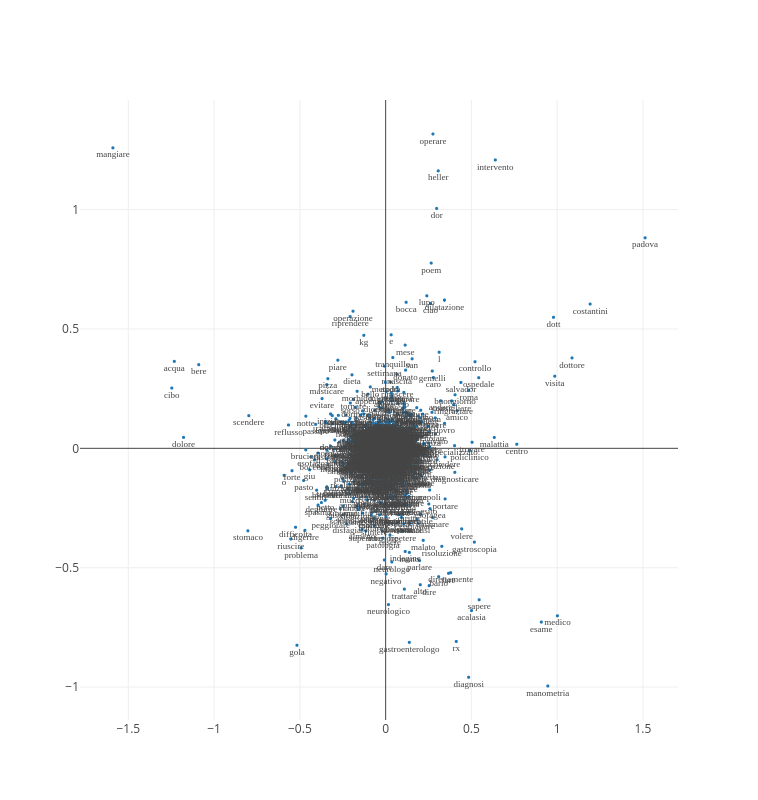

In [99]:
plot_lsa2D(-1*tls[:,1], tls[:,2], ord_terms)

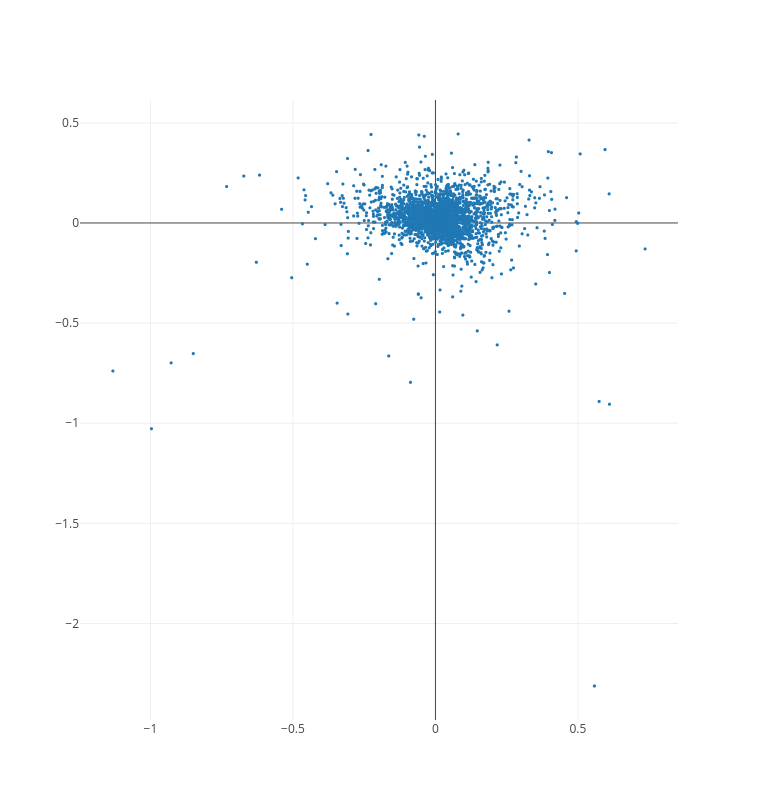

In [100]:
plot_lsa2D(-1*dls[:,1], dls[:,2])

## Distribuzione delle tipologie di incidenti

In [104]:
doc_classes.value_counts()

Neutral     2198
Negative     745
Positive     350
Name: class, dtype: int64

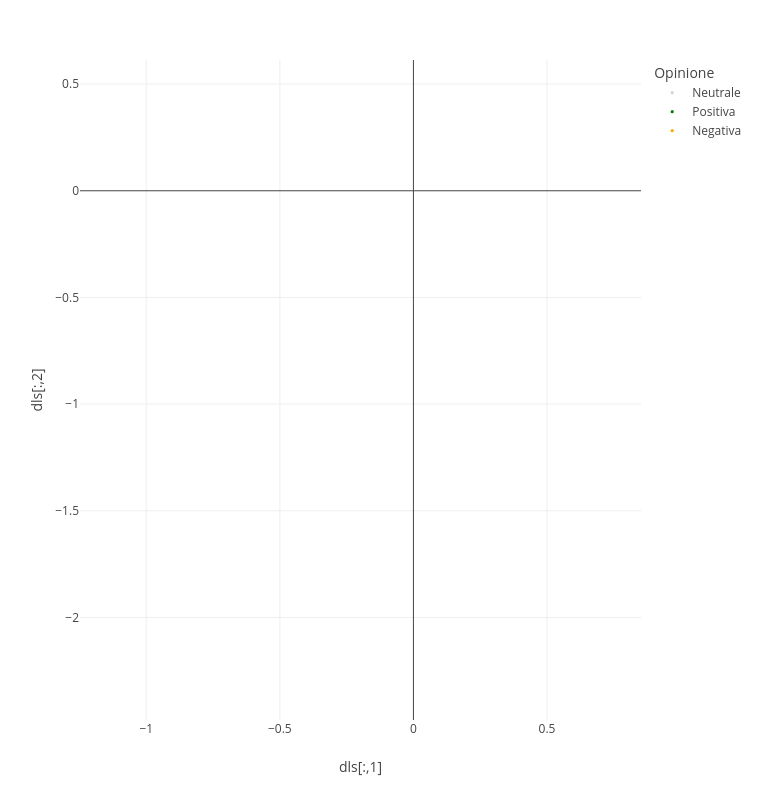

In [105]:
dfc = pd.DataFrame(
    {"Opinione" : doc_classes,
     "dls[:,1]" : -1*dls[:,1],
     "dls[:,2]" : dls[:,2]}
)

dfc.Opinione = dfc.Opinione.cat.rename_categories(
    {"Neutral" : "Neutrale",
     "Positive" : "Positiva",
     "Negative" : "Negativa"})
s
fig = px.scatter(
    dfc,
    x="dls[:,1]",
    y="dls[:,2]",
    color="Opinione",
    color_discrete_map=
        {"Neutrale": "lightgrey",
         "Positiva": "green",
         "Negativa": "orange"},
    template="none",
    height=800
)
    
fig.update_traces(marker=dict(size=3,))
fig.show()

## Analisi termini e documenti

In [106]:
with np.errstate(invalid = "ignore", divide = "ignore"):
    tlsn = norm(tls, 2, axis = 1)
    dlsn = norm(dls, 2, axis = 1)
    tlsn = tls / tlsn[:,None]
    dlsn = dls / dlsn[:,None]

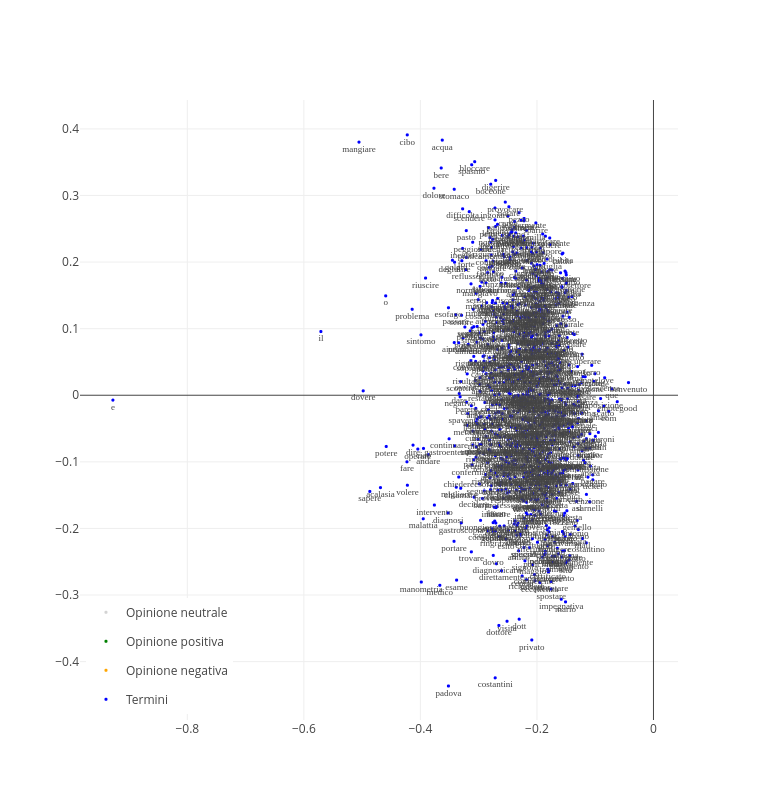

In [107]:
plot_lsa2D_termdoc(
    doc_classes,
    -1*dlsn[:,0],
    dlsn[:,1],
    -1*tlsn[:,0],
    tlsn[:,1],
    ord_terms
).update_layout(legend=dict(
    yanchor="bottom",
    y=0.01,
    xanchor="left",
    x=0.01
)).show()

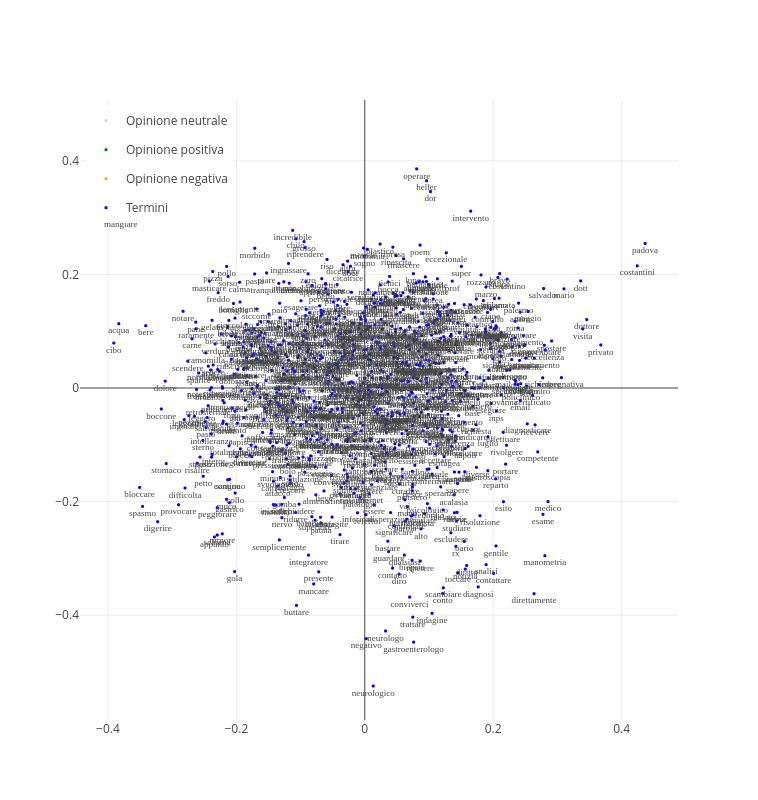

In [108]:
plot_lsa2D_termdoc(
    doc_classes,
    -1*dlsn[:,1],
    dlsn[:,2],
    -1*tlsn[:,1],
    tlsn[:,2],
    ord_terms
).update_layout(legend=dict(
    yanchor="top",
    y=0.99,
    xanchor="left",
    x=0.01
)).show()

## Costruzione di un'interrogazione

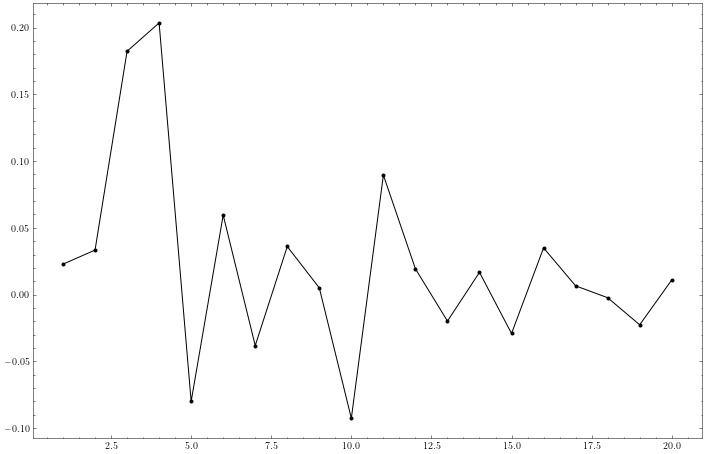

In [109]:
plot_knee_points(s);

In [120]:
knee = 6
qterms = ["costantini", "padova"]
_, _, _, qls, _, _ = makequery(qterms, tdm, U, s, vocabulary);
qlsn = norm(qls, 2)
qlsn = qls / qlsn

m = dls[:,0:knee]
q = qls[0:knee]
docs = doc_classes

ranks = get_similar(
    m,
    q,
    docs,
    threshold = 0.2,
    topn = 482
)

query_matching_idxs = [rank[0] for rank in ranks]
sim_scores = [rank[2] for rank in ranks]

In [121]:
[rank[1] for rank in ranks[:10]]

['Neutral',
 'Neutral',
 'Neutral',
 'Neutral',
 'Positive',
 'Positive',
 'Neutral',
 'Neutral',
 'Positive',
 'Neutral']

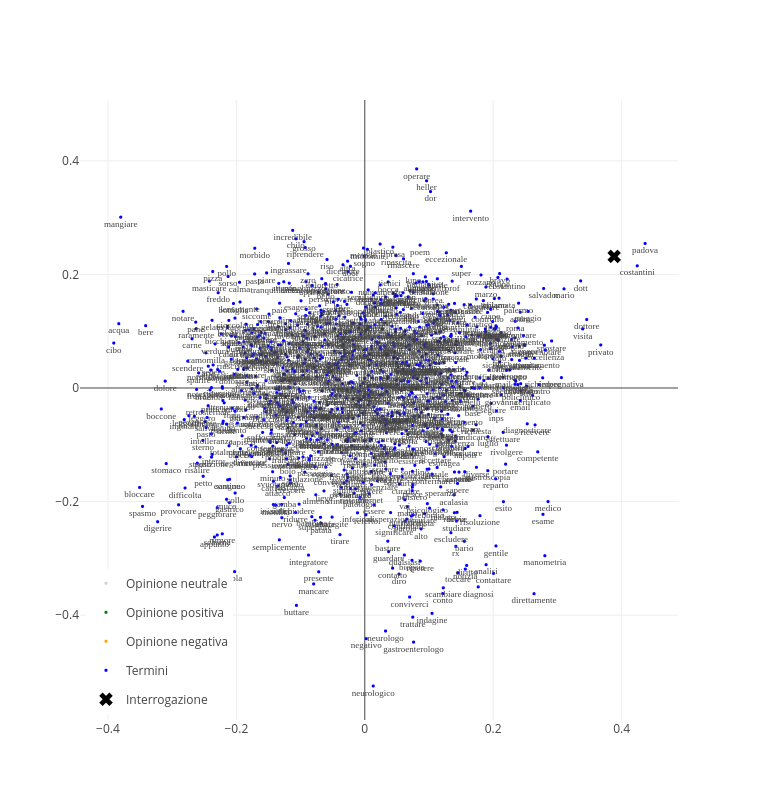

In [122]:
query_trace = go.Scatter(
    x = [-1*qlsn[1]],
    y = [qlsn[2]],
    mode = "markers",
    name = "Interrogazione",
    marker = dict(
        size = 12,
        color = "black",
        symbol = "x"
    )
)

plot_lsa2D_termdoc(
    doc_classes,
    -1*dlsn[:,1],
    dlsn[:,2],
    -1*tlsn[:,1],
    tlsn[:,2],
    ord_terms
).update_layout(legend=dict(
    yanchor="bottom",
    y=0.01,
    xanchor="left",
    x=0.01
)).add_trace(query_trace).show()

In [123]:
qclasses = ["Positive"]
dls_rows = dls.shape[0]
classes = doc_classes

chisquare_lsa(
    qclasses,
    qterms,
    query_matching_idxs, 
    classes,
    dls_rows
)

Pearson's Chi-squared test with 1 ddof
--------------------------------------

Observed frequencies
+-----------------------+----------------+------------+
|                       |   not Positive |   Positive |
|-----------------------+----------------+------------|
| not costantini_padova |           2540 |        271 |
| costantini_padova     |            403 |         79 |
+-----------------------+----------------+------------+

Expected frequencies
+-----------------------+----------------+------------+
|                       |   not Positive |   Positive |
|-----------------------+----------------+------------|
| not costantini_padova |        2512.23 |   298.77   |
| costantini_padova     |         430.77 |    51.2299 |
+-----------------------+----------------+------------+

X-squared: 	19.731698265888852
p-value 	8.911097275270677e-06


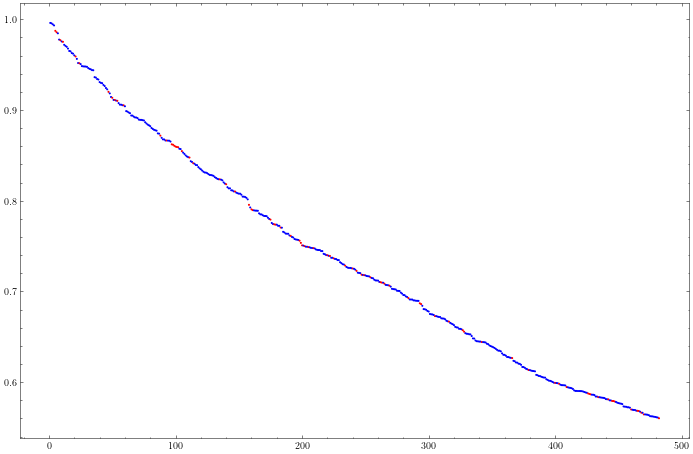

In [135]:
r = 482
destroyed_idx = np.asarray(doc_classes == "Positive")
destroyed_entries = np.asarray(
    [1 if destroyed_idx[idx] == 1 else 0 for idx in query_matching_idxs]
)

plt.figure(figsize=(12, 8))
plt.scatter(
    np.linspace(1, r, r),
    sim_scores,
    c = destroyed_entries,
    marker = "o",
    cmap = "bwr",
    s = 1
)
plt.show()

## Costruzione di un'interrogazione articolata

In [125]:
knee = 6
r = 482
tlsn = norm(tls[:,0:knee], 2, axis = 1)

In [140]:
docs = doc_classes
qterms = ["costantini", "dott"]
_, _, _, qls, _, _ = makequery(qterms, tdm, U, s, vocabulary);

docs_ranked1, terms_ranked1, norms1 = \
    get_query_result(
        docs,
        ord_terms,
        dls[:,0:knee],
        tls[:,0:knee],
        qls[0:knee], 
        tlsn,
        high=0.9,
        r=r
    )
docs_matching_query1 = [rank[0] for rank in docs_ranked1]

In [141]:
ranked_terms = [(rank[2], rank[1], norm) for rank, norm in zip(terms_ranked1, norms1)]
ranked_terms.sort(key=lambda y: y[2], reverse=True)
ranked_terms

[(0.9368591134969754, 'padova', 2.304474624596494),
 (0.9751232405965233, 'costantini', 1.8358387648726255),
 (0.9309217152957876, 'dott', 1.3944239000026064),
 (0.913457955189287, 'visita', 1.3564727815033195),
 (0.9576638420176601, 'salvador', 0.690390195728992),
 (0.926910319513809, 'mail', 0.3636916821871443),
 (0.9809614712710693, 'mario', 0.32749872821288023),
 (0.9195545916839309, 'abano', 0.2798675892405577),
 (0.968390745445914, 'andro', 0.1943467968231425),
 (0.9225403036774487, 'antonio', 0.18494644137457683),
 (0.9145843753126206, 'impegnativa', 0.16345206234615098),
 (0.9253905157882462, 'privatamente', 0.15178391919770343),
 (0.9297412553384239, 'spostare', 0.14778231287933985),
 (0.9357646858794078, 'sant', 0.13424142577037243),
 (0.9371489174755102, 'pagamento', 0.12891464502720293),
 (0.9073782476312932, 'chiamata', 0.12702291971008123),
 (0.910762738907661, 'telefono', 0.11253515103213614)]

In [142]:
knee = 6
qterms = ["costantini", "dott", "salvador"]
_, _, _, qls, _, _ = makequery(qterms, tdm, U, s, vocabulary);

docs_ranked2, terms_ranked2, norms2 = \
    get_query_result(
        docs,
        ord_terms,
        dls[:,0:knee],
        tls[:,0:knee],
        qls[0:knee], 
        tlsn,
        high=0.9,
        r=r
    )
docs_matching_query2 = [rank[0] for rank in docs_ranked2]

In [143]:
ranked_terms = [(rank[2], rank[1], norm) for rank, norm in zip(terms_ranked2, norms2)]
ranked_terms.sort(key=lambda y: y[2], reverse=True)
ranked_terms

[(0.9364261737147761, 'padova', 2.304474624596494),
 (0.9759093573367179, 'costantini', 1.8358387648726255),
 (0.9283978685431855, 'dott', 1.3944239000026064),
 (0.9121161519229029, 'visita', 1.3564727815033195),
 (0.9617768718153193, 'salvador', 0.690390195728992),
 (0.9218486415794641, 'mail', 0.3636916821871443),
 (0.9843592384016459, 'mario', 0.32749872821288023),
 (0.9196811267843673, 'abano', 0.2798675892405577),
 (0.9667653140204369, 'andro', 0.1943467968231425),
 (0.9261170660941276, 'antonio', 0.18494644137457683),
 (0.910704785686532, 'impegnativa', 0.16345206234615098),
 (0.9254044983916201, 'privatamente', 0.15178391919770343),
 (0.9256865557572542, 'spostare', 0.14778231287933985),
 (0.9383201777066494, 'sant', 0.13424142577037243),
 (0.9341845073825864, 'pagamento', 0.12891464502720293),
 (0.9161893920586694, 'telefono', 0.11253515103213614)]

In [144]:
get_matching_docs(docs_matching_query1, docs_matching_query2)

475

In [145]:
qclasses = ["Positive"]
dls_rows = dls.shape[0]
classes = doc_classes

chisquare_lsa(
    qclasses,
    qterms,
    docs_matching_query3, 
    classes,
    dls_rows
)

Pearson's Chi-squared test with 1 ddof
--------------------------------------

Observed frequencies
+------------------------------+----------------+------------+
|                              |   not Positive |   Positive |
|------------------------------+----------------+------------|
| not costantini_dott_salvador |           2537 |        274 |
| costantini_dott_salvador     |            406 |         76 |
+------------------------------+----------------+------------+

Expected frequencies
+------------------------------+----------------+------------+
|                              |   not Positive |   Positive |
|------------------------------+----------------+------------|
| not costantini_dott_salvador |        2512.23 |   298.77   |
| costantini_dott_salvador     |         430.77 |    51.2299 |
+------------------------------+----------------+------------+

X-squared: 	15.698753417677665
p-value 	7.427310456431828e-05


In [131]:
qterms = ["costantini", "dott", "salvador", "padova"]
_, _, _, qls, _, _ = makequery(qterms, tdm, U, s, vocabulary);

docs_ranked3, terms_ranked3, norms3 = \
    get_query_result(
        docs,
        ord_terms,
        dls[:,0:knee],
        tls[:,0:knee],
        qls[0:knee], 
        tlsn,
        high=0.9,
        r=r
    )
docs_matching_query3 = [rank[0] for rank in docs_ranked3]

In [132]:
ranked_terms = [(rank[2], rank[1], norm) for rank, norm in zip(terms_ranked3, norms3)]
ranked_terms.sort(key=lambda y: y[2], reverse=True)
ranked_terms

[(0.9448686729743547, 'padova', 2.304474624596494),
 (0.9770410532007215, 'costantini', 1.8358387648726255),
 (0.9389728901078833, 'dott', 1.3944239000026064),
 (0.9186116075160071, 'visita', 1.3564727815033195),
 (0.9659274799938137, 'salvador', 0.690390195728992),
 (0.9199589897533835, 'mail', 0.3636916821871443),
 (0.9806242479311524, 'mario', 0.32749872821288023),
 (0.9299541590072347, 'abano', 0.2798675892405577),
 (0.9721749764197214, 'andro', 0.1943467968231425),
 (0.9197806593759053, 'antonio', 0.18494644137457683),
 (0.9110617277305626, 'impegnativa', 0.16345206234615098),
 (0.9273214122986299, 'privatamente', 0.15178391919770343),
 (0.9327117252301678, 'spostare', 0.14778231287933985),
 (0.9379062623507917, 'sant', 0.13424142577037243),
 (0.9422435506342197, 'pagamento', 0.12891464502720293),
 (0.911430182969043, 'chiamata', 0.12702291971008123),
 (0.9176943310575624, 'telefono', 0.11253515103213614)]

In [133]:
get_matching_docs(docs_matching_query1, docs_matching_query3)

474

In [134]:
qclasses = ["Positive"]
qterms = ["costantini", "dott", "salvador", "padova"]
dls_rows = dls.shape[0]
classes = doc_classes

chisquare_lsa(
    qclasses,
    qterms,
    docs_matching_query3, 
    classes,
    dls_rows
)

Pearson's Chi-squared test with 1 ddof
--------------------------------------

Observed frequencies
+-------------------------------------+----------------+------------+
|                                     |   not Positive |   Positive |
|-------------------------------------+----------------+------------|
| not costantini_dott_salvador_padova |           2537 |        274 |
| costantini_dott_salvador_padova     |            406 |         76 |
+-------------------------------------+----------------+------------+

Expected frequencies
+-------------------------------------+----------------+------------+
|                                     |   not Positive |   Positive |
|-------------------------------------+----------------+------------|
| not costantini_dott_salvador_padova |        2512.23 |   298.77   |
| costantini_dott_salvador_padova     |         430.77 |    51.2299 |
+-------------------------------------+----------------+------------+

X-squared: 	15.698753417677665
p-valu